In [1]:
import findspark
findspark.init()

In [2]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.feature import CountVectorizer, IDF, StopWordsRemover, Tokenizer
from pyspark.ml.classification import NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

import string

import warnings
warnings.filterwarnings("ignore")

In [3]:
spark = SparkSession.builder.appName('FakeRealNews').getOrCreate()

# <font color='Mediumblue'>Table Contents</font> </br>

<details>
    <summary>Click for details</summary>


1. [Overview about data](#overview) <br/> <br />

2. [Pre-process data](#preprocess) <br /> <br />

    2.1. [Cleaning dataset](#clean)
    
    > 2.1.1. [Dealing with leaking information 1](#leak1)
    
    > > [Cleaning text function](#clean1)
    
    > 2.1.2. [Dealing with leaking information 2](#leak2)
    
    > 2.1.3. [Remove duplicates](#dup)
    
    2.2. [Feature Transformations](#NLP)
<br>

3. [Building model](#model)<br /> <br />
    
    3.1. [Naive Bayes](#naive)
    
    > 3.1.1 [Naive Bayes with title column](#title)
    
    > 3.1.2 [Naive Bayes with text column](#text)
    
    3.2. [Random Forest](#tree)

<br>     
</details>

## <a name="overview">1. Overview about data</a>

#### <a name="fake">1.1. Overview about fake news data</a>

In [4]:
fake = spark.read.csv("fake-and-real-news-dataset/Fake.csv", inferSchema = True, header = True)

In [5]:
fake.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



In [6]:
fake.count()

23489

In [7]:
fake.show(3)

+--------------------+--------------------+-------+-----------------+
|               title|                text|subject|             date|
+--------------------+--------------------+-------+-----------------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|
+--------------------+--------------------+-------+-----------------+
only showing top 3 rows



<b> Add column Fake/Real and Fake is 0</b>

In [8]:
fake = fake.withColumn("Fake/Real", lit(0))
fake.show()

+--------------------+--------------------+-------+-----------------+---------+
|               title|                text|subject|             date|Fake/Real|
+--------------------+--------------------+-------+-----------------+---------+
| Donald Trump Sen...|Donald Trump just...|   News|December 31, 2017|        0|
| Drunk Bragging T...|House Intelligenc...|   News|December 31, 2017|        0|
| Sheriff David Cl...|On Friday, it was...|   News|December 30, 2017|        0|
| Trump Is So Obse...|On Christmas day,...|   News|December 29, 2017|        0|
| Pope Francis Jus...|Pope Francis used...|   News|December 25, 2017|        0|
| Racist Alabama C...|The number of cas...|   News|December 25, 2017|        0|
| Fresh Off The Go...|Donald Trump spen...|   News|December 23, 2017|        0|
| Trump Said Some ...|In the wake of ye...|   News|December 23, 2017|        0|
| Former CIA Direc...|Many people have ...|   News|December 22, 2017|        0|
| WATCH: Brand-New...|Just when you mig.

#### <a name="true">1.2 Overview about true news data</a>

In [9]:
real = spark.read.csv("fake-and-real-news-dataset/True.csv", inferSchema = True, header = True)

In [10]:
real.printSchema()

root
 |-- title: string (nullable = true)
 |-- text: string (nullable = true)
 |-- subject: string (nullable = true)
 |-- date: string (nullable = true)



In [11]:
real.count()

21417

In [12]:
real.show(3)

+--------------------+--------------------+------------+------------------+
|               title|                text|     subject|              date|
+--------------------+--------------------+------------+------------------+
|As U.S. budget fi...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
|U.S. military to ...|WASHINGTON (Reute...|politicsNews|December 29, 2017 |
|Senior U.S. Repub...|WASHINGTON (Reute...|politicsNews|December 31, 2017 |
+--------------------+--------------------+------------+------------------+
only showing top 3 rows



<b> Add column Fake/Real and Real is 1</b>

In [13]:
real = real.withColumn("Fake/Real", lit(1))
real.show()

+--------------------+--------------------+--------------------+------------------+---------+
|               title|                text|             subject|              date|Fake/Real|
+--------------------+--------------------+--------------------+------------------+---------+
|As U.S. budget fi...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |        1|
|U.S. military to ...|WASHINGTON (Reute...|        politicsNews|December 29, 2017 |        1|
|Senior U.S. Repub...|WASHINGTON (Reute...|        politicsNews|December 31, 2017 |        1|
|FBI Russia probe ...|WASHINGTON (Reute...|        politicsNews|December 30, 2017 |        1|
|Trump wants Posta...|SEATTLE/WASHINGTO...|        politicsNews|December 29, 2017 |        1|
|White House, Cong...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |        1|
|Trump says Russia...|WEST PALM BEACH, ...|        politicsNews|December 29, 2017 |        1|
|Factbox: Trump on...|The following sta...|        politicsN

#### <a name="combine">1.3 Combine two dataframes</a>

In [14]:
data = fake.union(real) 
data.describe().show()

+-------+--------------------+--------------------+--------------------+--------------------+------------------+
|summary|               title|                text|             subject|                date|         Fake/Real|
+-------+--------------------+--------------------+--------------------+--------------------+------------------+
|  count|               44906|               44898|               44898|               44898|             44906|
|   mean|                NULL|                NULL|                50.0|   1245.142857142857|0.4769295862468267|
| stddev|                NULL|                NULL|                 0.0|    986.147796321868|0.4994730337719483|
|    min| #AfterTrumpImplo...|                    |  the witness sai...|              #Obama|                 0|
|    max|“You’re Not Welco...|youngers these da...|” Trump told the ...|” she said.  “It’...|                 1|
+-------+--------------------+--------------------+--------------------+--------------------+---

## <a name="preprocess">2. Pre-process data</a>

### <a name="clean">2.1 Cleaning dataset </a>

#### <a name="leak1">2.1.1 Dealing with leaking information 1 </a>

Analysing the dataset, we found that nearly 99.2% of the true news contains the word "(Reuters)" and this can lead to missunderstanding in the model. Hence we will be doing basic natural language processing cleaning by formating the text.

In [15]:
real.filter(real.text.contains("(Reuters)")).count() * 100 / real.count()

99.17822290703647

In [16]:
data = data.withColumn('text', regexp_replace('text', '(Reuters)', ''))
data.filter(data.text.contains("(Reuters)")).count()

0

##### <a name="clean1">Cleaning text function </a>

In [17]:
def cleaning_text(data, col_name):
    '''
    This function helps to:
        1. Remove all singular letters except 'a'.
        2. Expand all words with contractions.('re -> are).
        3. Remove all numbers.
        4. Remove all extra spaces.
        5. Lowcase text.
        
        Params:
            data: pyspark.DataFrame
            col_name: name columns to clean
        
        Return:
            Data cleaned
    '''
    alphabet = list(string.ascii_lowercase)
    alphabet = alphabet[1:]
    
    for letter in alphabet:
        data = data.withColumn(col_name, regexp_replace(col_name, ' '+letter+' ', ' '))
    
    data = data.withColumn(col_name, regexp_replace(col_name, ' re', 'are'))\
               .withColumn(col_name, regexp_replace(col_name, ' ve', 'have'))\
               .withColumn(col_name, regexp_replace(col_name, ' ll', 'will'))\
               .withColumn(col_name, regexp_replace(col_name, '[^\w\s]+', ''))
    
    data = data.withColumn(col_name, regexp_replace(col_name, r'\d+', ''))\
               .withColumn(col_name, regexp_replace(col_name, '\s+', ' '))

    data = data.withColumn(col_name, lower(data[col_name]))
    
    return data

In [18]:
data = cleaning_text(data, 'text')
data = cleaning_text(data, 'title')
data.show(5)

+--------------------+--------------------+-------+-----------------+---------+
|               title|                text|subject|             date|Fake/Real|
+--------------------+--------------------+-------+-----------------+---------+
| donald trump sen...|donald trump just...|   News|December 31, 2017|        0|
| drunk bragging t...|house intelligenc...|   News|December 31, 2017|        0|
| sheriff david cl...|on friday it wasa...|   News|December 30, 2017|        0|
| trump is so obse...|on christmas day ...|   News|December 29, 2017|        0|
| pope francis jus...|pope francis used...|   News|December 25, 2017|        0|
+--------------------+--------------------+-------+-----------------+---------+
only showing top 5 rows



#### <a name="leak2">2.1.2 Dealing with leaking information 2</a>

Noticed that all news before 2016 were fake news and this is a dead giveaway, which can lead to very high accuracy. Also, some date values are filled with URLs instead hence cleaning will be done.

Observing this information leak, we can easily train the model to detect fake/real just by passing in the dates.
However, today's date will probably not tell us any information about whether a news story published today is real or fake.
Hence we will not be using dates to perform regression as it can lead to artificially high accuracy.

Text(0.5, 1.0, 'Articles published per day')

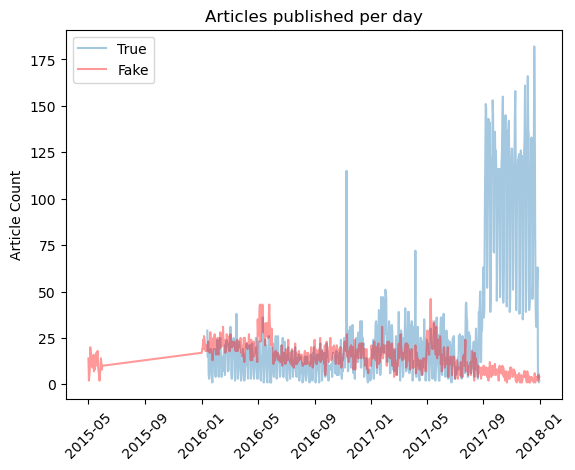

In [19]:
true_news_date = real.select('date', 'Fake/Real').toPandas()
fake_news_date = fake.select('date', 'Fake/Real').toPandas()

tnews = pd.to_datetime(true_news_date.date, errors = 'coerce').value_counts().sort_index()
fnews = pd.to_datetime(fake_news_date.date, errors = 'coerce').value_counts().sort_index()

plt.plot(tnews.index, tnews.values, label='True', alpha=0.4)
plt.plot(fnews.index, fnews.values, 'red', label='Fake', alpha=0.4)

plt.xticks(rotation = 45)

plt.ylabel("Article Count")
plt.legend(loc = 'upper left')
plt.title("Articles published per day")

#### <a name="dup">2.1.3 Remove duplicates</a>

In [20]:
data = data.dropDuplicates()

#### <a name="NLP">2.2 Feature Transformations</a>

In [21]:
data = data.drop('date')
data = data.dropna()

In [22]:
tokenizer1 = Tokenizer(inputCol="text", outputCol="token_text")
tokenizer2 = Tokenizer(inputCol="title", outputCol='token_title')

stopremove1 = StopWordsRemover(inputCol='token_text',outputCol='stop_tokens_text')
stopremove2 = StopWordsRemover(inputCol='token_title', outputCol='stop_tokens_title')

count_vec1 = CountVectorizer(inputCol='stop_tokens_text',outputCol='c_vec_text')
count_vec2 = CountVectorizer(inputCol='stop_tokens_title', outputCol='c_vec_title')

idf1 = IDF(inputCol="c_vec_text", outputCol="idf_text")
idf2 = IDF(inputCol="c_vec_title", outputCol='idf_title')

## <a name="model">3. Building model</a>

### <a name="naive">3.1 Naive Bayes</a>

#### <a name="title">3.1.1 Naive Bayes with title column</a>

In [23]:
data_prep_pipe = Pipeline(stages = [tokenizer2, stopremove2, count_vec2, idf2])
cleaner = data_prep_pipe.fit(data)
clean_data = cleaner.transform(data)

In [24]:
clean_data = clean_data.select(['idf_title','Fake/Real'])
clean_data.show(10)

+--------------------+---------+
|           idf_title|Fake/Real|
+--------------------+---------+
|(28163,[1,16,43,5...|        0|
|(28163,[1,86,118,...|        0|
|(28163,[1,6,11,13...|        0|
|(28163,[0,1,5,18,...|        0|
|(28163,[0,1,599,6...|        0|
|(28163,[0,1,13,16...|        0|
|(28163,[0,1,2,212...|        0|
|(28163,[0,1,39,43...|        0|
|(28163,[0,1,2,15,...|        0|
|(28163,[0,1,55,14...|        0|
+--------------------+---------+
only showing top 10 rows



In [25]:
train_data, test_data = clean_data.randomSplit([0.7, 0.3], seed=35)

In [26]:
nb = NaiveBayes(featuresCol = 'idf_title', labelCol = 'Fake/Real')

predictor = nb.fit(train_data)
test_results = predictor.transform(test_data)

test_results.groupBy('Fake/Real', 'prediction').count().show()

+---------+----------+-----+
|Fake/Real|prediction|count|
+---------+----------+-----+
|        1|       0.0|  496|
|        0|       0.0| 6713|
|        1|       1.0| 5910|
|        0|       1.0|  265|
+---------+----------+-----+



In [27]:
acc_eval = MulticlassClassificationEvaluator(labelCol="Fake/Real")
acc = acc_eval.evaluate(test_results)
print("Accuracy of model at predicting: {}".format(acc))

Accuracy of model at predicting: 0.943081973068089


In [28]:
precision = acc_eval.evaluate(test_results, {acc_eval.metricName: "precisionByLabel",
                                             acc_eval.metricLabel: 0.0})
precision

0.9311971147177139

In [29]:
recall = acc_eval.evaluate(test_results, {acc_eval.metricName: "recallByLabel",
                                          acc_eval.metricLabel: 0.0})
recall

0.9620235024362281

<b>The performance of our model seems pretty good, with accuracy of 94% detect fake news, precision of 93% and recall of 96%. This mean if we just know the title of the news there are 94% chances model knows that is a fake or real news </b>

<b> That give us the hope that with knowing all the text the acc will increase.</b>

#### <a name="title">3.1.2 Naive Bayes with text column</a>

In [30]:
data_prep_pipe_2 = Pipeline(stages = [tokenizer1, stopremove1, count_vec1, idf1])
cleaner_2 = data_prep_pipe_2.fit(data)
clean_data_2 = cleaner_2.transform(data)

In [31]:
clean_data_2 = clean_data_2.select(['idf_text','Fake/Real'])
clean_data_2.show(3)

+--------------------+---------+
|            idf_text|Fake/Real|
+--------------------+---------+
|(262144,[1,3,4,11...|        0|
|(262144,[0,3,4,18...|        0|
|(262144,[0,1,3,4,...|        0|
+--------------------+---------+
only showing top 3 rows



In [32]:
train_data_2, test_data_2 = clean_data_2.randomSplit([0.7, 0.3], seed=35)

In [33]:
nb_2 = NaiveBayes(featuresCol = 'idf_text', labelCol = 'Fake/Real')

predictor_2 = nb_2.fit(train_data_2)
test_results_2 = predictor_2.transform(test_data_2)

test_results_2.groupBy('Fake/Real', 'prediction').count().show()

+---------+----------+-----+
|Fake/Real|prediction|count|
+---------+----------+-----+
|        1|       0.0|  206|
|        0|       0.0| 6861|
|        1|       1.0| 6060|
|        0|       1.0|  257|
+---------+----------+-----+



In [34]:
acc_2 = acc_eval.evaluate(test_results_2)
print("Accuracy of model at predicting: {}".format(acc_2))

Accuracy of model at predicting: 0.9654143728989646


In [35]:
precision_2 = acc_eval.evaluate(test_results_2, {acc_eval.metricName: "precisionByLabel",
                                                acc_eval.metricLabel: 0.0})
precision_2

0.9708504315834159

In [36]:
recall_2 = acc_eval.evaluate(test_results_2, {acc_eval.metricName: "recallByLabel",
                                              acc_eval.metricLabel: 0.0})
recall_2

0.9638943523461646

As we predicted when know all the text the model have a better accuracy than just know the title (96% > 94%) the precision and recall seems good too. Now let check the random forest model for the text column.

### <a name="tree">3.2 Random Forest</a>

In [37]:
rf = RandomForestClassifier(labelCol="Fake/Real", featuresCol="idf_title", maxDepth = 3)

In [38]:
predictor_3 = rf.fit(train_data)
test_results_3 = predictor_3.transform(test_data)
test_results_3.groupBy('Fake/Real', 'prediction').count().show()

+---------+----------+-----+
|Fake/Real|prediction|count|
+---------+----------+-----+
|        1|       0.0| 5114|
|        0|       0.0| 6896|
|        1|       1.0| 1292|
|        0|       1.0|   82|
+---------+----------+-----+



In [39]:
acc_3 = acc_eval.evaluate(test_results_3)
print("Accuracy of model at predicting: {}".format(acc_3))

Accuracy of model at predicting: 0.5376675849697449


<b>The acc of random forest is 53% however we can evaluate some hyperParameter like maxDepth or numTrees. With all respect i will choose the naive bayes model for this data.</b>